In [50]:
import sqlite3

In [52]:
connection = sqlite3.connect("mydb.db")

In [53]:
connection

In [54]:

table_creation_query="""
CREATE TABLE IF NOT EXISTS employees (
    emp_id INTEGER PRIMARY KEY,
    first_name TEXT NOT NULL,
    last_name TEXT NOT NULL,
    email TEXT UNIQUE NOT NULL,
    hire_date TEXT NOT NULL,
    salary REAL NOT NULL
);
"""

In [55]:
table_creation_query2="""
CREATE TABLE IF NOT EXISTS customers (
    customer_id INTEGER PRIMARY KEY AUTOINCREMENT,
    first_name TEXT NOT NULL,
    last_name TEXT NOT NULL,
    email TEXT UNIQUE NOT NULL,
    phone TEXT
);
"""


In [56]:

table_creation_query3="""
CREATE TABLE IF NOT EXISTS orders (
    order_id INTEGER PRIMARY KEY AUTOINCREMENT,
    customer_id INTEGER NOT NULL,
    order_date TEXT NOT NULL,
    amount REAL NOT NULL,
    FOREIGN KEY (customer_id) REFERENCES customers (customer_id)
);
"""

In [57]:
cursor = connection.cursor()

In [58]:
cursor.execute(table_creation_query)
cursor.execute(table_creation_query2)
cursor.execute(table_creation_query3)

In [59]:

insert_query = """
INSERT INTO employees (emp_id, first_name, last_name, email, hire_date, salary)
VALUES (?, ?, ?, ?, ?, ?);
"""


insert_query_customers = """
INSERT INTO customers (customer_id, first_name, last_name, email, phone)
VALUES (?, ?, ?, ?, ?);
"""

insert_query_orders = """
INSERT INTO orders (order_id, customer_id, order_date, amount)
VALUES (?, ?, ?, ?);
"""

In [60]:
employee_data = [
    (1, "Sunny", "Savita", "sunny.sv@abc.com", "2023-06-01", 50000.00),
    (2, "Arhun", "Meheta", "arhun.m@gmail.com", "2022-04-15", 60000.00),
    (3, "Alice", "Johnson", "alice.johnson@jpg.com", "2021-09-30", 55000.00),
    (4, "Bob", "Brown", "bob.brown@uio.com", "2020-01-20", 45000.00)
]

customers_data = [
    (1, "John", "Doe", "john.doe@example.com", "1234567890"),
    (2, "Jane", "Smith", "jane.smith@example.com", "9876543210"),
    (3, "Emily", "Davis", "emily.davis@example.com", "4567891230"),
    (4, "Michael", "Brown", "michael.brown@example.com", "7894561230")
]

orders_data = [
    (1, 1, "2023-12-01", 250.75),
    (2, 2, "2023-11-20", 150.50),
    (3, 3, "2023-11-25", 300.00),
    (4, 4, "2023-12-02", 450.00)
]

In [61]:
cursor.executemany(insert_query,employee_data)
cursor.executemany(insert_query_customers,customers_data)
cursor.executemany(insert_query_orders,orders_data)

In [63]:
connection.commit()

In [64]:
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

from typing import Annotated, Literal
from langchain_core.messages import AIMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages
from typing import Any
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode
from langchain_community.utilities import SQLDatabase

In [65]:
db=SQLDatabase.from_uri("sqlite:///mydb.db")

In [66]:
db.dialect

'sqlite'

In [67]:
db.get_usable_table_names()

['customers', 'employees', 'orders']

In [68]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="llama3-70b-8192")

In [69]:
llm.invoke("hello how are you?")

AIMessage(content="Hello! I'm just a language model, so I don't have feelings like humans do, but I'm functioning properly and ready to help you with any questions or tasks you may have. How can I assist you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 15, 'total_tokens': 61, 'completion_time': 0.149535064, 'prompt_time': 0.000175198, 'queue_time': 0.284453835, 'total_time': 0.149710262}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_bf16903a67', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--3163b608-db1c-407b-bbf5-ecbd66ff027e-0', usage_metadata={'input_tokens': 15, 'output_tokens': 46, 'total_tokens': 61})

In [70]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

In [71]:
toolkit=SQLDatabaseToolkit(db=db, llm=llm)

In [72]:
tools=toolkit.get_tools()

In [73]:
tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x0000018AC627E350>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x0000018AC627E350>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x0000018AC627E350>),
 QuerySQLCheckerTool(description='Use this tool to 

In [74]:
for tool in tools:
    print(tool.name)

sql_db_query
sql_db_schema
sql_db_list_tables
sql_db_query_checker


In [75]:
list_tables_tool = next((tool for tool in tools if tool.name == "sql_db_list_tables"), None)

In [76]:
list_tables_tool

ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x0000018AC627E350>)

In [77]:
list_tables_tool.invoke("")

'customers, employees, orders'

In [78]:
get_schema_tool = next((tool for tool in tools if tool.name == "sql_db_schema"), None)

In [79]:
get_schema_tool

InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x0000018AC627E350>)

In [80]:
print(get_schema_tool.invoke("customers"))


CREATE TABLE customers (
	customer_id INTEGER, 
	first_name TEXT NOT NULL, 
	last_name TEXT NOT NULL, 
	email TEXT NOT NULL, 
	phone TEXT, 
	PRIMARY KEY (customer_id), 
	UNIQUE (email)
)

/*
3 rows from customers table:
customer_id	first_name	last_name	email	phone
1	John	Doe	john.doe@example.com	1234567890
2	Jane	Smith	jane.smith@example.com	9876543210
3	Emily	Davis	emily.davis@example.com	4567891230
*/


In [81]:
llm_to_get_schema=llm.bind_tools([get_schema_tool])

In [ ]:
from langchain_core.tools import tool
@tool
def query_to_database(query:str)->str:
    """
    Execute the SQL query which will be given as parameter query to this function and do not assume any data, only return the real data that comes as output after executing the provided query
    If the query is invalid or returns no result, an error message will be returned.
    In case of an error, the user is advised to rewrite the query and try again.
    """
    result=db.run_no_throw(query)
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    return result

In [153]:
query_to_database.invoke("SELECT * FROM orders;")

"[(1, 1, '2023-12-01', 250.75), (2, 2, '2023-11-20', 150.5), (3, 3, '2023-11-25', 300.0), (4, 4, '2023-12-02', 450.0)]"

In [84]:
llm_with_tools=llm.bind_tools([query_to_database])

In [85]:
llm_with_tools.invoke("SELECT * FROM Employees;")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'c0mhnd589', 'function': {'arguments': '{"query":"SELECT * FROM Employees;"}', 'name': 'query_to_database'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 924, 'total_tokens': 972, 'completion_time': 0.195025711, 'prompt_time': 0.038408685, 'queue_time': 0.286163145, 'total_time': 0.233434396}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_bf16903a67', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5d69b660-c699-470d-9047-a0837e78aaba-0', tool_calls=[{'name': 'query_to_database', 'args': {'query': 'SELECT * FROM Employees;'}, 'id': 'c0mhnd589', 'type': 'tool_call'}], usage_metadata={'input_tokens': 924, 'output_tokens': 48, 'total_tokens': 972})

In [86]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [87]:
def handle_tool_error(state:State):
    error = state.get("error") 
    tool_calls = state["messages"][-1].tool_calls
    return { "messages": [ ToolMessage(content=f"Error: {repr(error)}\n please fix your mistakes.",tool_call_id=tc["id"],) for tc in tool_calls ] }

def create_node_from_tool_with_fallback(tools:list)-> RunnableWithFallbacks[Any, dict]:
    return ToolNode(tools).with_fallbacks([RunnableLambda(handle_tool_error)], exception_key="error")

In [88]:
list_tables=create_node_from_tool_with_fallback([list_tables_tool])
get_schema=create_node_from_tool_with_fallback([get_schema_tool])
query_database=create_node_from_tool_with_fallback([query_to_database])

In [89]:
from langchain_core.prompts import ChatPromptTemplate

query_check_system = """You are a SQL expert. Carefully review the SQL query for common mistakes, including:

Issues with NULL handling (e.g., NOT IN with NULLs)
Improper use of UNION instead of UNION ALL
Incorrect use of BETWEEN for exclusive ranges
Data type mismatches or incorrect casting
Quoting identifiers improperly
Incorrect number of arguments in functions
Errors in JOIN conditions

If you find any mistakes, rewrite the query to fix them. If it's correct, reproduce it as is."""

query_check_prompt = ChatPromptTemplate.from_messages([("system", query_check_system), ("placeholder", "{messages}")])

check_generated_query = query_check_prompt | llm_with_tools

In [90]:
check_generated_query.invoke({"messages": [("user", "SELECT * FROM Employees LIMIT 5;")]})

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'acgdkbgx9', 'function': {'arguments': '{"query":"SELECT * FROM Employees LIMIT 5;"}', 'name': 'query_to_database'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 1025, 'total_tokens': 1076, 'completion_time': 0.197511302, 'prompt_time': 0.041638125, 'queue_time': 0.27188483500000005, 'total_time': 0.239149427}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_bf16903a67', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e54e742c-2cbf-4d17-a1eb-21925a1346c6-0', tool_calls=[{'name': 'query_to_database', 'args': {'query': 'SELECT * FROM Employees LIMIT 5;'}, 'id': 'acgdkbgx9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1025, 'output_tokens': 51, 'total_tokens': 1076})

In [152]:
check_generated_query.invoke({"messages": [("user", "SELECT +++ FROM Employees LIMITs 5;")]})

AIMessage(content="I've reviewed the SQL query and found a few mistakes.\n\nHere's the corrected query:\n\n```sql\nSELECT * FROM Employees LIMIT 5;\n```\n\nExplanation:\n\n* `+++` is not a valid column identifier. I assume you meant to use `*` to select all columns.\n* `LIMITs` is a typo and should be `LIMIT`.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 1026, 'total_tokens': 1099, 'completion_time': 0.349917386, 'prompt_time': 0.04265476, 'queue_time': 0.310492766, 'total_time': 0.392572146}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_bf16903a67', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--f38fd419-bcd6-401b-b559-ddd4b61e953e-0', usage_metadata={'input_tokens': 1026, 'output_tokens': 73, 'total_tokens': 1099})

In [92]:
class SubmitFinalAnswer(BaseModel):
    """Submit the final answer to the user based on the query results."""
    final_answer: str = Field(..., description="The final answer to the user")
    
llm_with_final_answer=llm.bind_tools([SubmitFinalAnswer])

In [133]:
# Add a node for a model to generate a query based on the question and schema
query_gen_system_prompt = """You are a SQL expert with a strong attention to detail.Given an input question, output a syntactically correct SQLite query to run, then look at the results of the query and return the answer.

1. DO NOT call any tool besides SubmitFinalAnswer to submit the final answer.

When generating the query:

2. Output the SQL query that answers the input question without a tool call.

3. Only limit the number of results if the user specifically requests a limited number.

4. You can order the results by a relevant column to return the most interesting examples in the database.

5. Never query for all the columns from a specific table, only ask for the relevant columns given the question.

6. If you get an error while executing a query, rewrite the query and try again.

7. If you get an empty result set, you should try to rewrite the query to get a non-empty result set.

8. NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information.

9. If you have enough information to answer the input question, simply invoke the appropriate tool to submit the final answer to the user.

10. DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database. Do not return any sql query except answer. """

query_gen_prompt = ChatPromptTemplate.from_messages([("system", query_gen_system_prompt), ("placeholder", "{messages}")])

query_generator = query_gen_prompt | llm_with_final_answer

In [134]:
query_generator.invoke({"messages": [("can you fetch the data from employee table?")]})

AIMessage(content='Here is the SQLite query to fetch data from the employee table:\n\n```\nSELECT * FROM employee;\n```\n\nLet me execute this query and see what the results are...\n\n(Please provide the result set or an error message if any)', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 1177, 'total_tokens': 1225, 'completion_time': 0.244974799, 'prompt_time': 0.062225027, 'queue_time': 0.282733733, 'total_time': 0.307199826}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_bf16903a67', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--4f6ededa-a605-4125-918f-51dee3a73a05-0', usage_metadata={'input_tokens': 1177, 'output_tokens': 48, 'total_tokens': 1225})

In [135]:
def first_tool_call(state:State)->dict[str,list[AIMessage]]:
    print(f"state from first_tool_call: {state}")
    return{"messages": [AIMessage(content="",tool_calls=[{"name":"sql_db_list_tables","args":{},"id":"tool_abcd123"}])]}

In [136]:
def check_the_given_query(state:State):
    print(f"state from check the given query: {state}")
    return {"messages": [check_generated_query.invoke({"messages": [state["messages"][-1]]})]}

In [137]:
def generation_query(state:State):
    message = query_generator.invoke(state)
    print(f"state from generation_query: {state}")

    # Sometimes, the LLM will hallucinate and call the wrong tool. We need to catch this and return an error message.
    tool_messages = []
    if message.tool_calls:
        for tc in message.tool_calls:
            if tc["name"] != "SubmitFinalAnswer":
                tool_messages.append(
                    ToolMessage(
                        content=f"Error: The wrong tool was called: {tc['name']}. Please fix your mistakes. Remember to only call SubmitFinalAnswer to submit the final answer. Generated queries should be outputted WITHOUT a tool call.",
                        tool_call_id=tc["id"],
                    )
                )
    else:
        tool_messages = []
    return {"messages": [message] + tool_messages}

In [138]:
def should_continue(state:State):
    print(f"state from should_continue: {state}")
    messages = state["messages"]
    last_message = messages[-1]
    print("last message")
    print(last_message)
    if getattr(last_message, "tool_calls", None):
        print("sooo")
        return END
    elif last_message.content.startswith("Error:"):
        print("dooo")
        return "query_gen"
    else:
        print("oooo")
        return "correct_query"

In [139]:
def llm_get_schema(state:State):
    print("state from llm_get_schema", state)
    response = llm_to_get_schema.invoke(state["messages"])
    return {"messages": [response]}

In [140]:
workflow = StateGraph(State)
workflow.add_node("first_tool_call",first_tool_call)
workflow.add_node("list_tables_tool", list_tables)
workflow.add_node("get_schema_tool", get_schema)
workflow.add_node("model_get_schema", llm_get_schema)
workflow.add_node("query_gen", generation_query)
workflow.add_node("correct_query", check_the_given_query)
workflow.add_node("execute_query", query_database)

In [141]:
workflow.add_edge(START, "first_tool_call")
workflow.add_edge("first_tool_call", "list_tables_tool")
workflow.add_edge("list_tables_tool", "model_get_schema")
workflow.add_edge("model_get_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_gen")
workflow.add_conditional_edges("query_gen",should_continue,
                            {END:END,
                            "correct_query":"correct_query"})
workflow.add_edge("correct_query", "execute_query")
workflow.add_edge("execute_query", "query_gen")

In [142]:
app=workflow.compile()

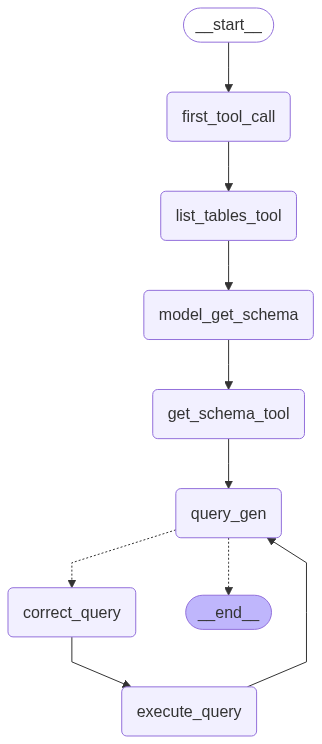

In [143]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [149]:
query={"messages": [("user", "show all data from table orders? my table has 4 rows but you are showing three only")]}

In [150]:
response=app.invoke(query)

state from first_tool_call: {'messages': [HumanMessage(content='show all data from table orders? my table has 4 rows but you are showing three only', additional_kwargs={}, response_metadata={}, id='dd868655-43a0-49fd-8e27-a19304f60b2f')]}
state from llm_get_schema {'messages': [HumanMessage(content='show all data from table orders? my table has 4 rows but you are showing three only', additional_kwargs={}, response_metadata={}, id='dd868655-43a0-49fd-8e27-a19304f60b2f'), AIMessage(content='', additional_kwargs={}, response_metadata={}, id='3d273575-d4b8-4c31-a90f-9fd0cbbd5a41', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'tool_abcd123', 'type': 'tool_call'}]), ToolMessage(content='customers, employees, orders', name='sql_db_list_tables', id='d21d939e-01cc-4235-8a0e-03cfc660b157', tool_call_id='tool_abcd123')]}
state from generation_query: {'messages': [HumanMessage(content='show all data from table orders? my table has 4 rows but you are showing three only', additional_

In [151]:
print(response["messages"][-1].tool_calls[0]["args"]["final_answer"])

The orders table has 3 rows: order_id	customer_id	order_date	amount
1	1	2023-12-01	250.75
2	2	2023-11-20	150.5
3	3	2023-11-25	300.0


In [147]:
# app.stream()

In [148]:
query = {"messages": [("user", "how many orders are there which is more than 300 rupees?")]}
response = app.invoke(query)

for msg in reversed(response["messages"]):
    if isinstance(msg, AIMessage) and msg.tool_calls:
        for tc in msg.tool_calls:
            if tc.get("name") == "SubmitFinalAnswer":
                print("✅ Final Answer:", tc["args"]["final_answer"])


state from first_tool_call: {'messages': [HumanMessage(content='how many orders are there which is more than 300 rupees?', additional_kwargs={}, response_metadata={}, id='0c631265-fcf9-4463-8588-f1cf243fef44')]}
state from llm_get_schema {'messages': [HumanMessage(content='how many orders are there which is more than 300 rupees?', additional_kwargs={}, response_metadata={}, id='0c631265-fcf9-4463-8588-f1cf243fef44'), AIMessage(content='', additional_kwargs={}, response_metadata={}, id='d11b1cf0-c02c-4589-bf48-66b9789e333e', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'tool_abcd123', 'type': 'tool_call'}]), ToolMessage(content='customers, employees, orders', name='sql_db_list_tables', id='5f9632bf-c427-45dc-a5f8-c5766e7209c5', tool_call_id='tool_abcd123')]}
state from generation_query: {'messages': [HumanMessage(content='how many orders are there which is more than 300 rupees?', additional_kwargs={}, response_metadata={}, id='0c631265-fcf9-4463-8588-f1cf243fef44'), AIMe